<a href="https://colab.research.google.com/github/mateollorente/Producto/blob/master/beatai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/SantiagoBuffa/BeatAI.git

fatal: destination path 'BeatAI' already exists and is not an empty directory.


In [3]:
from google.colab import userdata
import os, json

kaggle_username = userdata.get("kaggle_username")
kaggle_key = userdata.get("kaggle_key")

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!pip install kaggle --quiet

!kaggle datasets download -d evilspirit05/ecg-analysis -p ./data --unzip


Dataset URL: https://www.kaggle.com/datasets/evilspirit05/ecg-analysis
License(s): MIT
 84% 691M/826M [00:06<00:02, 67.5MB/s]
100% 826M/826M [00:07<00:00, 123MB/s] 


In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_dataset(dataset_path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        shear_range=0.05,
        validation_split=0.15
    )

    img_height, img_width = 256, 192
    batch_size = 16

    train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_path, 'train'),
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_path, 'train'),
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    # Generador de test (sin augmentation)
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        os.path.join(dataset_path, 'test'),
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

In [5]:
from tensorflow.keras import layers
import tensorflow as tf

class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Crear la capa solo una vez
        self.conv = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        spatial_attention = self.conv(concat)  # <--- NO crear aquí la capa
        return inputs * spatial_attention


In [6]:
def build_attention_model(img_height=256, img_width=192):
    inputs = layers.Input(shape=(img_height, img_width, 1))

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv1')(inputs)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2')(x)
    x = AttentionLayer(name='attn1')(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same', name='conv3')(x)
    x = AttentionLayer(name='attn2')(x)
    x = layers.MaxPooling2D(2,2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [7]:
import cv2
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    plt.imshow(img, cmap='gray')
    plt.imshow(heatmap_resized, cmap='jet', alpha=alpha)
    plt.axis('off')
    plt.show()

In [8]:
def visualize_attention(model, img_path, last_conv_layer='conv3'):
    """
    Genera y muestra Grad-CAM de una imagen de prueba usando el modelo dado.

    Args:
        model: Modelo Keras ya entrenado.
        img_path: Ruta a la imagen de prueba.
        last_conv_layer: Nombre de la última capa conv para Grad-CAM.
    """
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Cargar imagen
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")

    # Redimensionar
    img = cv2.resize(img, (192, 256))
    img_array = img.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=(0, -1))  # (1, 256, 192, 1)

    # Generar heatmap Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    # Visualizar superpuesto
    plt.imshow(img, cmap='gray')
    plt.imshow(cv2.resize(heatmap, (192, 256)), cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.show()


In [ ]:
ls -R ./data | head -40


./data:
ECG_DATA/

./data/ECG_DATA:
test/
train/

./data/ECG_DATA/test:
ECG Images of Myocardial Infarction Patients (240x12=2880)/
ECG Images of Patient that have abnormal heartbeat (233x12=2796)/
ECG Images of Patient that have History of MI (172x12=2064)/
Normal Person ECG Images (284x12=3408)/

./data/ECG_DATA/test/ECG Images of Myocardial Infarction Patients (240x12=2880):
MI(100).jpg
MI(101).jpg
MI(102).jpg
MI(103).jpg
MI(104).jpg
MI(105).jpg
MI(106).jpg
MI(107).jpg
MI(108).jpg
MI(109).jpg
MI(10).jpg
MI(110).jpg
MI(111).jpg
MI(112).jpg
MI(113).jpg
MI(114).jpg
MI(115).jpg
MI(116).jpg
MI(117).jpg
MI(118).jpg
MI(119).jpg
MI(11).jpg
MI(120).jpg
MI(121).jpg
MI(122).jpg
MI(123).jpg


Found 2572 images belonging to 4 classes.
Found 451 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


161/161 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.2878 - loss: 1.4230 - val_accuracy: 0.3171 - val_loss: 1.3639


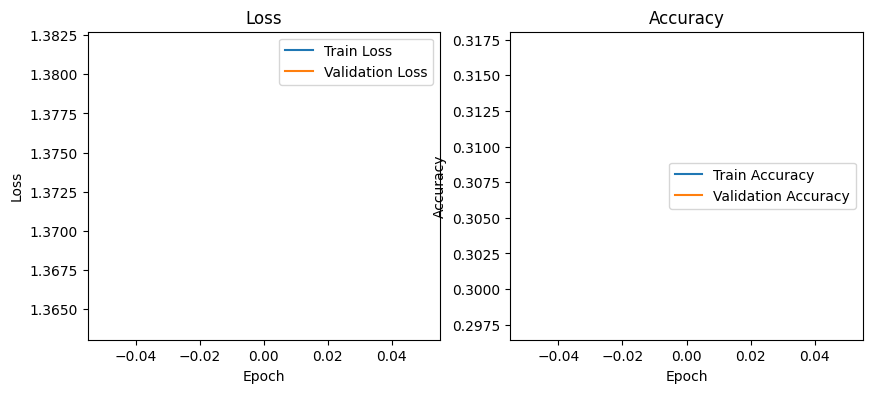

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 256, 192, 1))
  warnings.warn(msg)


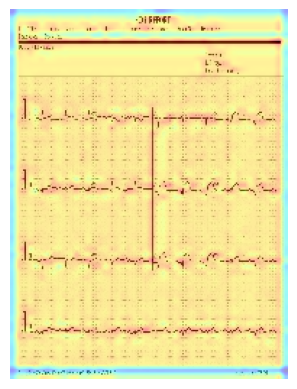

In [9]:
def show_graphs(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

dataset_path = "./data/ECG_DATA/"

train_gen, val_gen, test_gen = preprocess_dataset(dataset_path)

model = build_attention_model()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1
)

show_graphs(history)
img_test_path = "data/ECG_DATA/test/ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(100).jpg"
visualize_attention(model, img_test_path, last_conv_layer='conv3')

In [7]:
from google.colab import userdata
token = userdata.get("GITHUB_TOKEN")
!git pull
!git config user.name "mateollorente"
!git config user.email "mateollorente25@gmail.com"
!git remote set-url origin https://{token}@github.com/SantiagoBuffa/BeatAI.git






!git add models/ecg_attention_model.h5

!git commit -m "Guardar modelo entrenado"
!git push origin main

Already up to date.
fatal: pathspec 'models/ecg_attention_model.h5' did not match any files
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Everything up-to-date


In [5]:
%cd BeatAI
!git fetch origin
!git reset --hard origin/main


/content/BeatAI
HEAD is now at 16b903a lfs activated


In [20]:
import os
print(os.environ.get('GITHUB_TOKEN'))


None


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = build_attention_model()

checkpoint = ModelCheckpoint(
    "BeatAI/ecg_attention_model.h5",  # ruta dentro del repo
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint]
)

show_graphs(history)


In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

58/58 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5948 - loss: 1.3513
✅ Test Accuracy: 0.2575
